### Bedform Preservation Theory (Tested on bars)

This is code for testing bedform preservation statistical analysis on bars. 

(from candidacy proposal)
Theoretical and statistical relationships have also been leveraged to understand hydrodynamic and morphodynamic controls on river deposits. Bedform preservation theory suggests that the distribution of preserved bedform cross set heights in steady state systems has a coefficient of variation (CV) ~ 0.88 (Bridge, 1997; Paola and Borgman, 1991). Deviations from this baseline have been used to infer conditions of flow variability, and changes in the relative rates of bar and bedform migration, and channel avulsion (Ganti et al., 2020; Leary and Ganti, 2020; Lyster et al., 2022). These statistical trends provide an avenue for extracting flooding history and avulsion timescales from fluvial deposits.

Hypothesis: The distribution of bar heights in constant discharge NAYS2DH runs will have a CV = 0.88±0.2

_Methods_
TEST 1: Test Paola-Borgman theory for non-aggrading conditions (this model shouldn't be non-aggrading but this will be a baseline)

Datasets needed: 
- bed topography (equivalent to `xy_strat`) used to estimate thickness of preserved sets
- set heights (we can compare how good this estimation is to the stratigraphy?). Because of space4time, you should be able to take bed topography over a reach and compare it to set heights along a centreline in that reach and find how well the estimates fit the expected set height. But do we need the entire model run for this?
- find preservation ratio (mean set height/mean formative topography height)

TEST 2: Test Bridge + Best 1997 relationship for aggradational conditions
- Not sure how to test this relationship (s = lr/c + 0.8225 hm**2/hsd)
- Can evaluate $\alpha$ and $\beta$ parameter fits using the relationships in Bridge for dunes? Idk how they derived these relationships so may need to revisit this

TEST 3: Calculate T*, Tt, Tf and Preservation from Leary and Ganti 2019
- Need to revisit the way you are measuing wavelength? (they do consecutive crest, you have consecutive troughs, I don't think this matters)
- Tf might be the length of the model run, or maybe the length of deposition of the bar? Need more bar mapping for this (b/c in downstream)
- Need set heights again

#### IMPORT PACKAGES

In [6]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
from scipy.signal import savgol_filter

##### Define functions for PBT everything in CENTIMETERS

In [7]:
def beta(data):
    '''use PB91 definition to find beta value'''
    beta = np.divide(np.std(data)**2, np.nanmean(data))
    return beta

def alpha(data):
    '''use PB91 definition to find alpha value'''
    alpha = np.divide((np.nanmean(data))**2, np.std(data)**2)
    return alpha

def pseq6(x, alpha, beta):
    '''Calculate probability distribution of set thickness using Eq. 5 from Paola Borgman 1991'''
    xdomain = np.linspace(np.nanmin(x), np.nanmax(x))
    ps = np.divide(np.multiply(xdomain**(alpha-1), np.exp(-1*xdomain/beta)), np.multiply(beta**alpha, math.gamma(alpha)))
    return xdomain, ps

def line_eq(x, y):
    '''calculate components of gradient of a line'''
    grads = (y[1:]-y[:-1])/(x[1:]-x[:-1])
    ints = y[:-1]-(grads*x[:-1])
    dists = (((x[1:]-x[:-1])**2)+((y[1:]-y[:-1])**2))**0.5
    theta = np.arctan((y[1:]-y[:-1])/(x[1:]-x[:-1]))
    
    return (grads, ints, dists, theta)

#### Import all the main data

In [8]:
##### Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds
variabd = 0 #int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = 65 #int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)
fullsection = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/streamwise-masters/fullsections/{nickname}-centrefull.npy', allow_pickle = True)

/Volumes/SAF_Data/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-ud.npy


Test case where we define a time range over which to run the analysis

full section data order = (xy_strat, xy_topo, erohiatalsurf, shear, trueflow, flowvel, mmp)

In [9]:
end_t = datamaster.shape[2]
t_end = 381
t_init = 0

Text(0.5, 0, 'Streamwise distance, m (add 1000)')

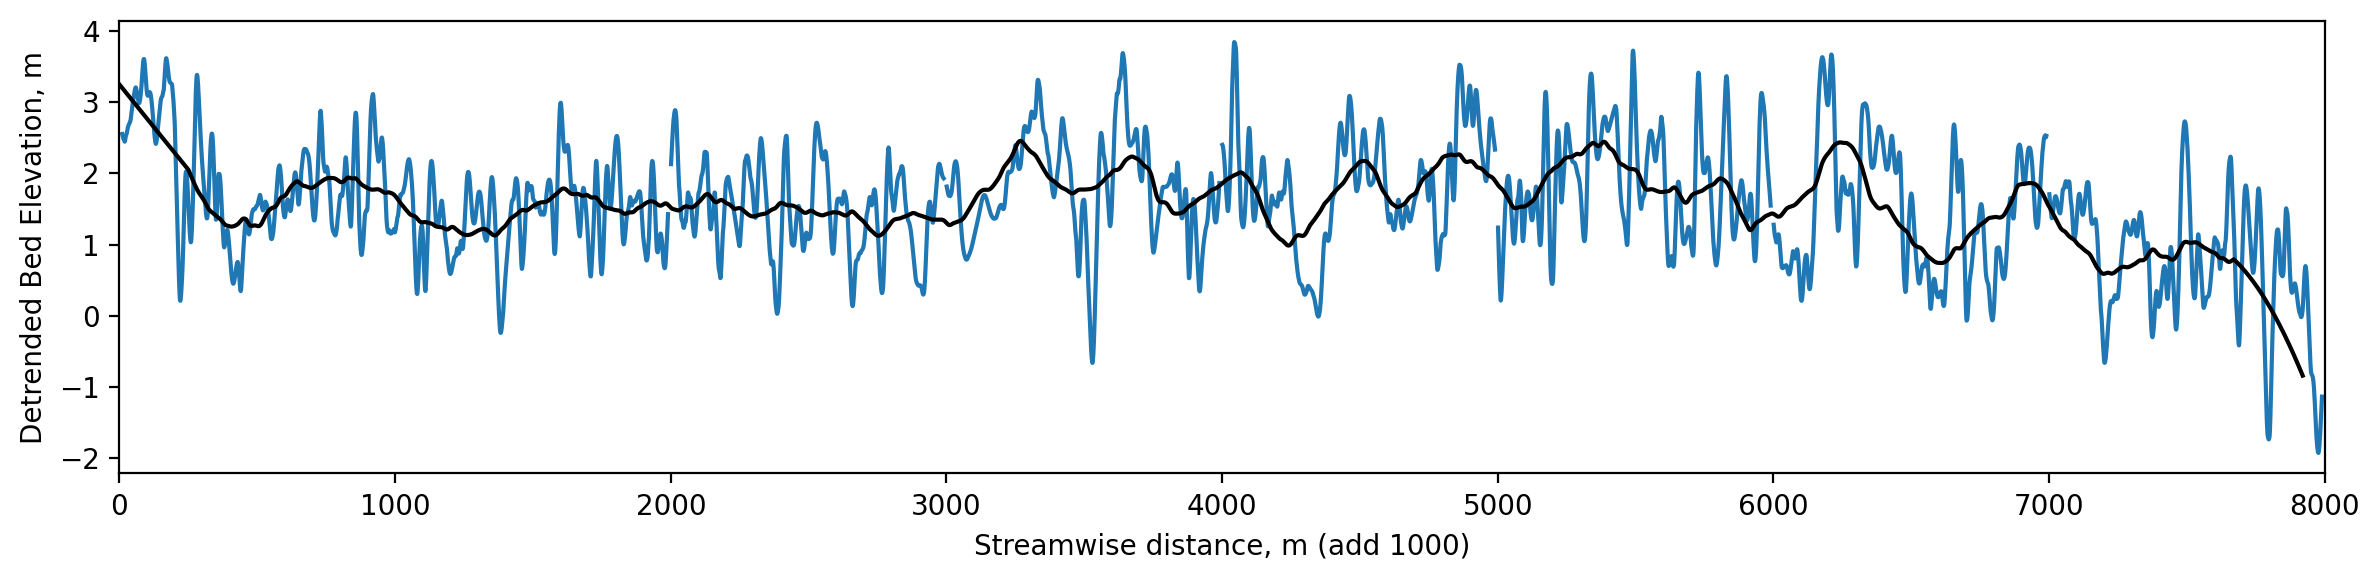

In [8]:
plt.figure(figsize = (12, 3), dpi = 200, tight_layout = True)
plt.plot(fullsection[t_end, :, 0])
plt.plot(savgol_filter(fullsection[t_end, :, 0][~np.isnan(fullsection[t_end, :, 0])], window_length = 501, polyorder = 2), 'k') # savgol filter cannnot use nan
plt.xlim(0, fullsection.shape[1])
plt.ylabel('Detrended Bed Elevation, m')
plt.xlabel('Streamwise distance, m (add 1000)')

### Some preliminary statistics on the data

#### Drift in mean bed elevaion


/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis, ddof=ddof) / a.mean(axis)


Text(0, 0.5, 'CV  per time')

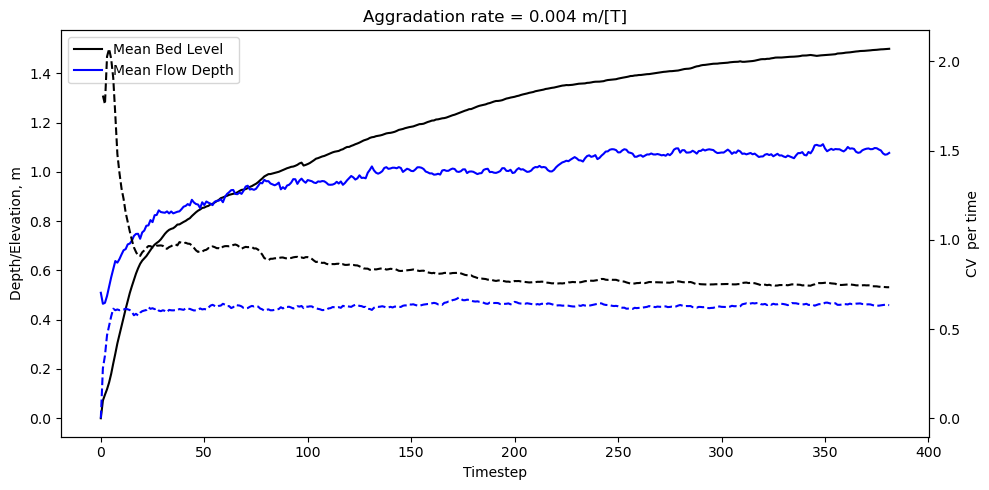

In [5]:
plt.figure(figsize = (10, 5), tight_layout = True, dpi = 100)
mean_bed = np.nanmean(datamaster[:, 7, :], axis = 0)
mean_depth = np.nanmean(datamaster[:, 4, :], axis = 0)
cv_bed = stats.variation(datamaster[:, 7, :], axis = 0)
cv_depth = stats.variation(datamaster[:, 4, :], axis = 0)
agg_rate = (mean_bed[-1]-mean_bed[0])/t_end ## average bed aggradation throughout the run
plt.plot(mean_bed, 'k', label = 'Mean Bed Level')
plt.plot(mean_depth, 'b', label = 'Mean Flow Depth')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Depth/Elevation, m')
plt.title(f'Aggradation rate = {np.round(agg_rate, 3)} m/[T]')
ax = plt.gca()
axr = ax.twinx()
axr.plot(cv_bed, 'k--', label = 'CV')
axr.plot(cv_depth, 'b--', label = 'CV')
axr.set_ylabel('CV  per time')

#### Distribution of bedform heights

In [10]:
u_end = 1000
d_end = 9000
xlocs = np.linspace(u_end, d_end, fullsection.shape[1])

In [11]:
rmvtruenans = np.where(np.isnan(fullsection[0, :, 0]))[0]
fullnonans = np.delete(fullsection, rmvtruenans, axis = 1)
xlocs_nonan = np.delete(xlocs, rmvtruenans) 

In [40]:
reset_bytime = fullnonans[:, :, 0]-fullnonans[:, :, 0].min(axis = 0)
reset_bytime.shape

(382, 7921)

(201,)


Text(0.5, 1.0, 'Bars along centreline?')

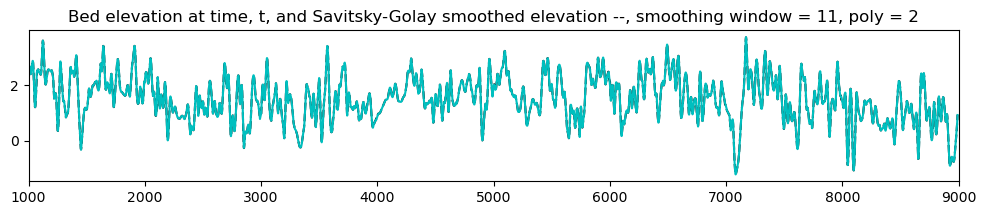

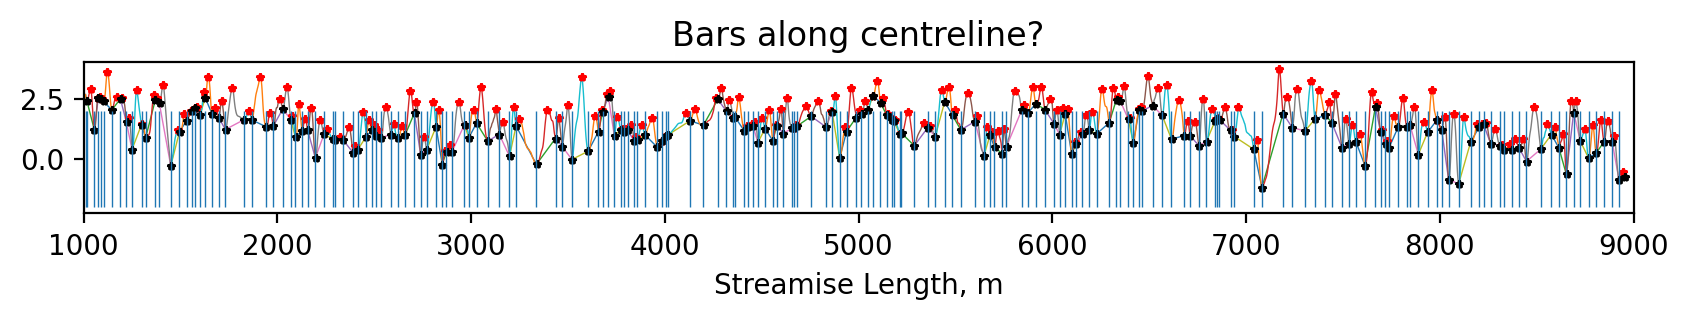

In [19]:
## Define timestep of bed topo of interest
t_topo = 300
window = 11

pol_ord = 2

moving_topo = savgol_filter(fullnonans[:, :, 0][t_topo, :][~np.isnan(fullnonans[:, :, 0][t_topo, :])], window, pol_ord, mode = 'interp')
pos_bars = xlocs_nonan[~np.isnan(fullnonans[:, :, 0][t_topo, :])]

plt.figure(figsize = (12, 2), dpi = 100)
plt.plot(pos_bars, moving_topo, 'k--')
plt.plot(xlocs_nonan, fullnonans[:, :, 0][t_topo, :], 'c-')
plt.xlim(1000, 9000)
plt.title(f'Bed elevation at time, t, and Savitsky-Golay smoothed elevation --, smoothing window = {window}, poly = {pol_ord}')

### USING MOVING AVERAGED TOPOGRAPHY
## to find the boundaries of the bar, we find the inflection points, i.e. where the dy/dx goes from -ve to +ve
plt.figure(figsize = (10, 1), dpi = 200)
#topo_grad, dips = movinggrad(moving_topo[1:], pos_bars)
topo_grad = (moving_topo[1:]-moving_topo[:-1])/(pos_bars[1:]-pos_bars[:-1])
## find inflection points
inflectx = np.insert(pos_bars[:-2][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)],
                     0, pos_bars[0]) ##x coords of the inflections
inflecty = np.insert(moving_topo[:-2][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)],
                     0, moving_topo[0]) #y coords of the inflection points

maxima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
minima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]
max_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
min_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]
print(inflecty.shape)
m, c, lengths, ang = line_eq(inflectx, inflecty)

## array of bar heights and array of bar lengths
heights = np.empty_like(m)
heightloc = np.empty_like(m)
# lengths = np.empty_like(m)

pos_idx = np.where(np.in1d(moving_topo,inflecty) == True)[0] ## indices where the inflection points occur
# # pos_idx = np.insert(pos_idx, 0, 0)

## initiate loop
for i in range (0, len(lengths)):
    xvals = np.linspace(inflectx[i], inflectx[i+1], pos_idx[i+1]-pos_idx[i]) ## need to make straight line to get the dimensions of the polygons
    yvals = m[i]*xvals + c[i]
    
    ## 
    vthick = np.nanmax(moving_topo[pos_idx[i]:pos_idx[i+1]]-yvals)
    heights[i] = vthick*np.cos(ang[i])
    heightloc[i] = inflectx[i]
    
    plt.plot(xvals, yvals, lw = 0.5)
    plt.plot(xvals, moving_topo[pos_idx[i]:pos_idx[i+1]], lw = 0.5)
plt.plot(max_xlocs, maxima, 'r*', ms = 3)
plt.plot(min_xlocs, minima, 'k*', ms = 3)
plt.vlines(heightloc, -2, 2, linewidth = 0.5)
plt.xlim(1000, 9000)
plt.xlabel('Streamise Length, m')
plt.title('Bars along centreline?')

In [20]:
successive_heights = maxima-(minima[:len(maxima)])
successive_heights_crop = successive_heights[successive_heights > 0.1*np.nanmean(fullsection[:, :, 4])]

Text(0.5, 0, 'Bar Height')

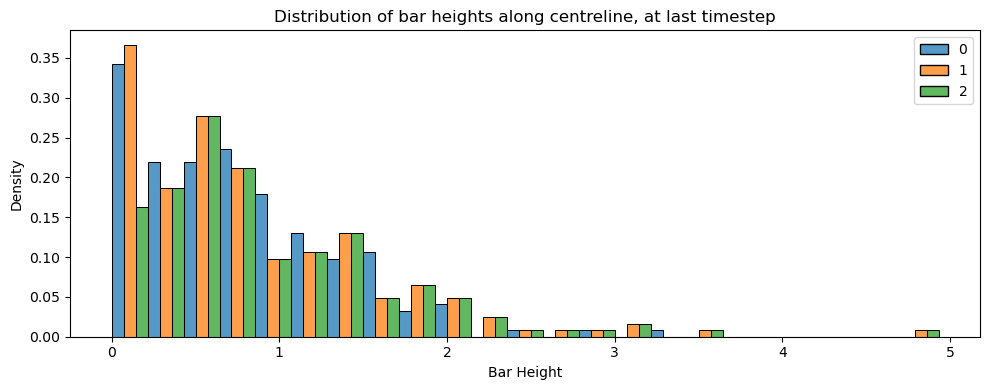

In [21]:
plt.figure(figsize = (10, 4), dpi = 100, tight_layout=True)
sns.histplot(data = [heights, successive_heights, successive_heights_crop], multiple = 'dodge', stat = 'density')
plt.title('Distribution of bar heights along centreline, at last timestep')
plt.xlabel('Bar Height')


In [16]:
print(np.mean(heights), np.std(heights))

0.7546474147715915 0.5884177520791259


Because they subsitiute space for time in Paola Borgman, we will use set heights for the stratigraphy built up to timestep `t_end`, and topographic heights (scour depths) at time `t_end`?

Recall from Paola & Borgman 1991:
a = $\frac{1}{\beta}$ and $\beta$ = $\frac{\sigma^2}{xm}$ where xm = mean topographic height, and $\sigma$ = SD of topographic height

## *Question for Liz*
In the PBT paper they measure Corea's bedform heights (successive minima and maxima) and get a pdf of that estimating the parameters using maximum likelihood estimates, then they use their predicted $\beta$ value from the bedform PDF to estimate the pdf for the set heights. They use a Chi test to validate both fits _*do I have to use MLE and do a similar thing here?*_

For their comparison to the braided river, they estimate the gamma function (using 3-params) (from where idk, they don't say) <br>
In Vamsi's MH paper, they also don't say how they get their $\beta$ value, just that $\alpha$ = 5

**Max. Likelihood Estimates from PB91**

Define a log-likelihood function for a given set of samples $s_i$ as:
$$
L(a) = a^n - a \sum_{i=1}^{n} s_i + \sum^{n}_{i=1} ln(e^{-as_i} -1 - as_i) - 2\sum^{n}_{i=1} ln (1-e^{-as_i})
$$

the MLE estimate of a minimises this function (i.e. where the derivative = 0 in a trough)...<br>
**No, in the paper they just say you need to do this if the CV of your data isn't comparable to 0.881, Corea's is 0.76, like ours so I assume that means its ok??**

### Testing code with PB91 Data
Data from PB91 digitised using [WebPlotDigitizer (WPD)](https://apps.automeris.io/wpd/). <br>
Important to note, the gamma distribution parameterisation in scipy is coded differently to the distribution in PB91 (ofc, because noting can be easy -__-)<br>
Conversion is as follows:<br>
in **PB91**: $\alpha, \beta$ are called shape parameters <br>
in `scipy.stats.gamma`: $a$ is a *shape parameter*. Inputs are `stats.gamma.pdf(x, a = shape, loc = 0, scale = 1)` where a = PB91 $\alpha$, and `scale`= PB91 $\beta$, 

IF data does not start at 0 (like in the case where they use a 3 parama gamma), use `loc` to change the start location of the hump

In [17]:
# import data
ripple_hist = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/ripple_histPB_120.csv', delimiter = ',')
ripset_counts = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/histCounts_fig5.csv', delimiter = ',')
bars_hist = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/histCounts_fig9.csv', delimiter = ',')

ripple_pdf = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/fittedGamma_fig4.csv', delimiter = ',')
ripset_pdf = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/predictedPDF_fig5.csv', delimiter = ',')
braidset_pdf = np.genfromtxt('/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Paola-Borgman-Digitise/fittedGamma_fig9.csv', delimiter = ',')



##### Experimental ripple example

In [18]:
ripplesamples = np.array([])
for i, j in (ripple_hist):
    arrtoadd =np.ones(int(j))*(i)
    ripplesamples = np.concatenate((ripplesamples, arrtoadd), axis = 0)
    
ripsetsamples = np.array([])
for i, j in (ripset_counts):
    arrtoadd =np.ones(int(j))*(i)
    ripsetsamples = np.concatenate((ripsetsamples, arrtoadd), axis = 0)

In [19]:
ripple_beta = beta(ripplesamples)
ripple_alpha = alpha(ripplesamples)
ripplex, ripple_gamma = pseq6(ripplesamples, ripple_alpha, ripple_beta)

In [20]:
a_ripple = 1.681
b_ripple = 0.00524
loc = np.mean(ripplesamples)

xripple, psripple = pseq6([0, .03], a_ripple, b_ripple)
pdf = stats.gamma.pdf(x = ripplex,  a = ripple_alpha, scale=ripple_beta)
psrp2 = stats.gamma.pdf(x = xripple, a = a_ripple, scale = b_ripple)

#### use their params fos to get  out the mean and sd of the distrib

Text(0, 0.5, 'Probability Density cm$^{-1}$')

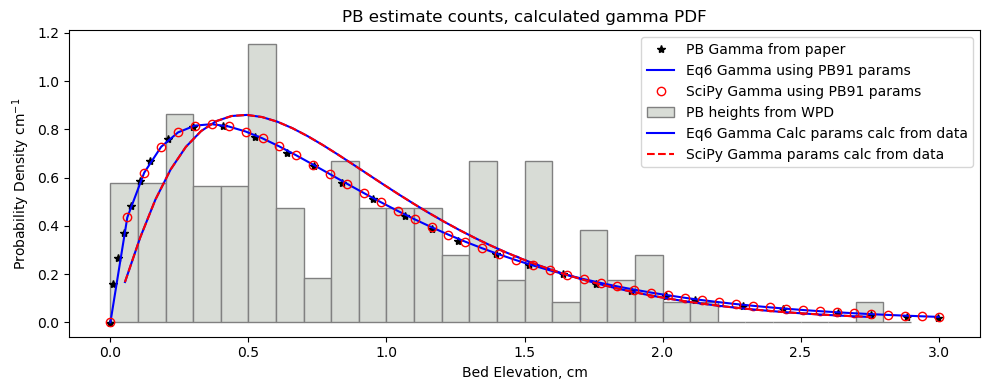

In [21]:
plt.figure(figsize = (10, 4), tight_layout = True, dpi = 100)
plt.plot(ripple_pdf[:, 0], ripple_pdf[:, 1], lw = 0, marker = '*', label = 'PB Gamma from paper', c = 'k')
plt.plot(xripple*100, psripple/100, 'b-', label = 'Eq6 Gamma using PB91 params')
plt.plot(xripple*100, psrp2/100, marker = 'o', label = 'SciPy Gamma using PB91 params', markerfacecolor = 'none', markeredgecolor = 'r', lw = 0)
plt.hist(ripplesamples, density = True, bins = np.arange(0, 3, step = 0.1), label = 'PB heights from WPD', fc = 'xkcd:light grey', ec = 'grey');
plt.title('PB estimate counts, calculated gamma PDF')
plt.plot(ripplex, ripple_gamma, 'b-', label = 'Eq6 Gamma Calc params calc from data')
plt.plot(ripplex, pdf, 'r--', label = 'SciPy Gamma params calc from data')
plt.legend()
plt.xlabel('Bed Elevation, cm')
plt.ylabel('Probability Density cm$^{-1}$')

Calculating preservation statistics

In [25]:
## calculating preservation
ripple_pres_exp = 1.645*(stats.variation(ripplesamples)**2)
true_pres = np.mean(ripsetsamples)/np.mean(ripplesamples)
print('Expected Pres:', np.round(ripple_pres_exp, 2))
print('actual preservation', np.round(true_pres, 2))

## calculating estimated set thickness using eq 5
set_thick_exp = 1.645*ripple_beta
set_thick_inthepaper = 0.8225*ripple_beta
print(f'Stolen data: expected set thicknesses using 0.8225: {np.round(set_thick_inthepaper/100, 4)}')
print('from the paper: expected set thickness = 0.0043m')
print(f'Calculated set thickness expected using 1.645 = {np.round(set_thick_exp/100, 4)}')

Expected Pres: 0.74
actual preservation 0.51
Stolen data: expected set thicknesses using 0.8225: 0.0032
from the paper: expected set thickness = 0.0043m
Calculated set thickness expected using 1.645 = 0.0064


*In the paper, this example uses the elevation difference between successive minima and maxima...and they use 0.8225 so is that what I'm meant to use, i really don't know anymore*

##### Braided river example

Text(0, 0.5, 'Probability Density m$^{-1}$')

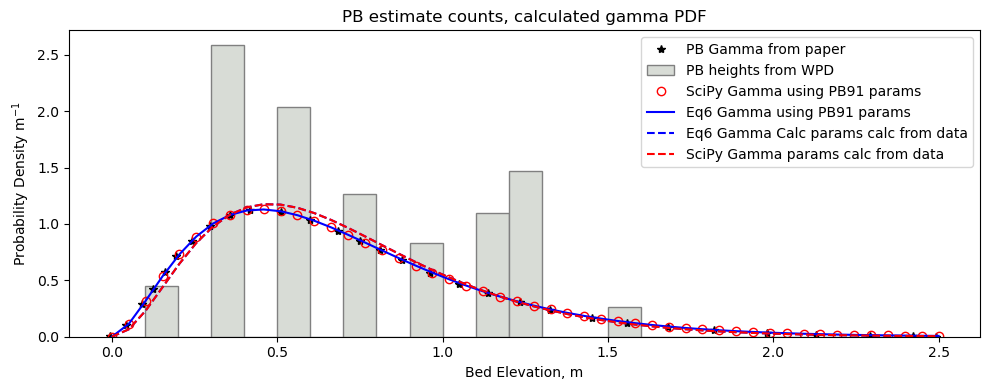

In [26]:
bathysamples = np.array([])
for i, j in (bars_hist):
    arrtoadd =np.ones(int(j))*(i)
    bathysamples = np.concatenate((bathysamples, arrtoadd), axis = 0)

## parameters from the paper
a_bathy = 2.78
b_bathy = 0.253
loc = np.mean(bathysamples)

## calculating fromsamples
bathy_alpha = alpha(bathysamples)
bathy_beta = beta(bathysamples)

xbar, psbar = pseq6([0, 2.5], a_bathy, b_bathy)
xbar, psbar_calc = pseq6([0, 2.5], bathy_alpha, bathy_beta)
pdf_ohau = stats.gamma.pdf(x = xbar,  a = bathy_alpha, scale=bathy_beta)
pdf_ohau_frompaper = stats.gamma.pdf(x = xbar, a = a_bathy, scale = b_bathy)

plt.figure(figsize = (10, 4), tight_layout = True, dpi = 100)
plt.plot(braidset_pdf[:, 0], braidset_pdf[:, 1], lw = 0, marker = '*', label = 'PB Gamma from paper', c = 'k')

plt.hist(bathysamples, density = True, bins = np.arange(0, 2.5, step = 0.1), label = 'PB heights from WPD', fc = 'xkcd:light grey', ec = 'grey');
plt.title('PB estimate counts, calculated gamma PDF')

plt.plot(xbar, pdf_ohau_frompaper, marker = 'o', label = 'SciPy Gamma using PB91 params', markerfacecolor = 'none', markeredgecolor = 'r', lw = 0)
plt.plot(xbar, psbar, 'b-', label = 'Eq6 Gamma using PB91 params')
plt.plot(xbar, psbar_calc, 'b--', label = 'Eq6 Gamma Calc params calc from data')
plt.plot(xbar, pdf_ohau, 'r--', label = 'SciPy Gamma params calc from data')
plt.legend()
plt.xlabel('Bed Elevation, m')
plt.ylabel('Probability Density m$^{-1}$')

In [27]:
bathypres = 1.645/bathy_alpha
print('Expected preservation using 1.645/alpha: ', np.round(bathypres, 2))

Expected preservation using 1.645/alpha:  0.52


Expected preservation using 1.645/$\alpha$ from paper = 0.59

### Applying code to NAYS2DH Data

(1) Check that depth and elevation data are interchangeable

(-5.0, 8.0)

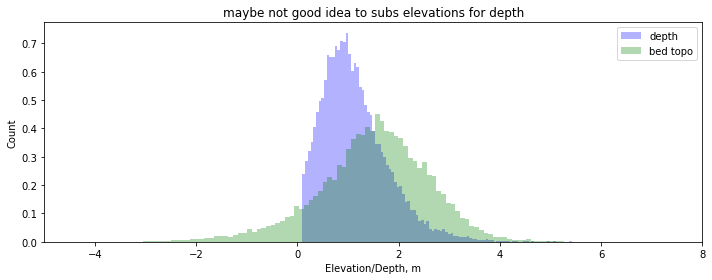

In [97]:
plt.figure(figsize = (10, 4), tight_layout=True)
plt.hist(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.1].ravel(), bins = 100, facecolor = 'b', alpha = 0.3, label = 'depth', density = True)
plt.hist(datamaster[:, 7, t_end][datamaster[:, 7, t_end]<7.5].ravel(), bins = 100, facecolor = 'g', alpha = 0.3, label = 'bed topo', density=True)
plt.ylabel('Count')
plt.xlabel('Elevation/Depth, m')
plt.title('maybe not good idea to subs elevations for depth')
plt.legend()
# plt.xlim(-5, 8)

Text(0.5, 1.0, 'Resetting elevations')

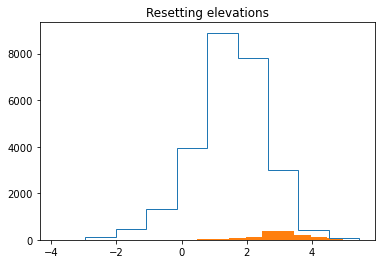

In [16]:
### changing reference frame of bed elevation so it is in relation to the deepest scour rather than the 0 elevation line
## find minimum elevation (scour depth, make that zero)
minelev = np.nanmin(datamaster[:, 7, t_end])
reset_elev = datamaster[:, 7, t_end][datamaster[:, 4, t_end]<0.1]# datamaster[:, 7, t_end]-minelev
plt.hist(datamaster[:, 7, t_end], histtype = 'step');
plt.hist(reset_elev);
plt.title('Resetting elevations')

In [25]:
### calculating alpha and beta for depth and elevation data
##------------------FOR DEPTH
a_dep = alpha(datamaster[:, 4, t_topo][datamaster[:, 4, t_topo]>0.009])
b_dep = beta(datamaster[:, 4, t_topo][datamaster[:, 4, t_topo]>0.009])
x_dep, pdf_dep_pb = pseq6(datamaster[:, 4, t_topo][datamaster[:, 4, t_topo]>0.009], a_dep, b_dep)

a_sucheights = alpha(successive_heights_crop)
b_sucheights = beta(successive_heights_crop)
x_sucheights, pdf_sucheights = pseq6(np.linspace(successive_heights_crop.min(), successive_heights_crop.max(), len(successive_heights_crop)), a_sucheights, b_sucheights)

In [ ]:
#------------------FOR BED TOPO
a_tpo = alpha(reset_elev)
b_tpo = beta(reset_elev)
x_tpo, pdf_tpo_pb = pseq6(reset_elev, a_tpo, b_tpo)
pdf_tpo_sc = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo)
pdf_tpo_sc = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo)
pdf_tpo_sc3 = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo, loc = np.mean(reset_elev))
pdf_tpo_sc_lnm = stats.lognorm.pdf(x_tpo, s = a_tpo, scale = b_tpo)


In [24]:
### calculating alpha and beta for depth and elevation data
##------------------FOR DEPTH
a_dep = alpha(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.009])
b_dep = beta(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.009])
x_dep, pdf_dep_pb = pseq6(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.009], a_dep, b_dep)
pdf_dep_sc = stats.gamma.pdf(x_dep, a = a_dep, scale = b_dep)

##------------------FOR BED TOPO
# a_tpo = alpha(datamaster[:, 7, t_end])
# b_tpo = beta(datamaster[:, 7, t_end])
# x_tpo, pdf_tpo_pb = pseq6(datamaster[:, 7, t_end], a_tpo, b_tpo)
# pdf_tpo_sc = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo)
# pdf_tpo_sc = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo)
# pdf_tpo_sc3 = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo, loc = np.mean(datamaster[:, 7, t_end]))
# pdf_tpo_sc_lnm = stats.lognorm.pdf(x_tpo, s = a_tpo, scale = b_tpo)

a_tpo_true = alpha(datamaster[:, 7, t_end])
b_tpo_true = beta(datamaster[:, 7, t_end])
a_tpo = alpha(reset_elev)
# a_tpo = 5 #like Vamsi
b_tpo = beta(reset_elev)
# b_tpo = 1/(np.nanmean(reset_elev))
x_tpo, pdf_tpo_pb = pseq6(reset_elev, a_tpo, b_tpo)
pdf_tpo_sc = stats.gamma.pdf(x_tpo, a = a_tpo, scale = b_tpo)

a_sucheights = alpha(successive_heights)
b_sucheights = beta(successive_heights)
x_sucheights, pdf_sucheights = pseq6(np.linspace(successive_heights.min(), successive_heights.max(), len(successive_heights)), a_sucheights, b_sucheights)


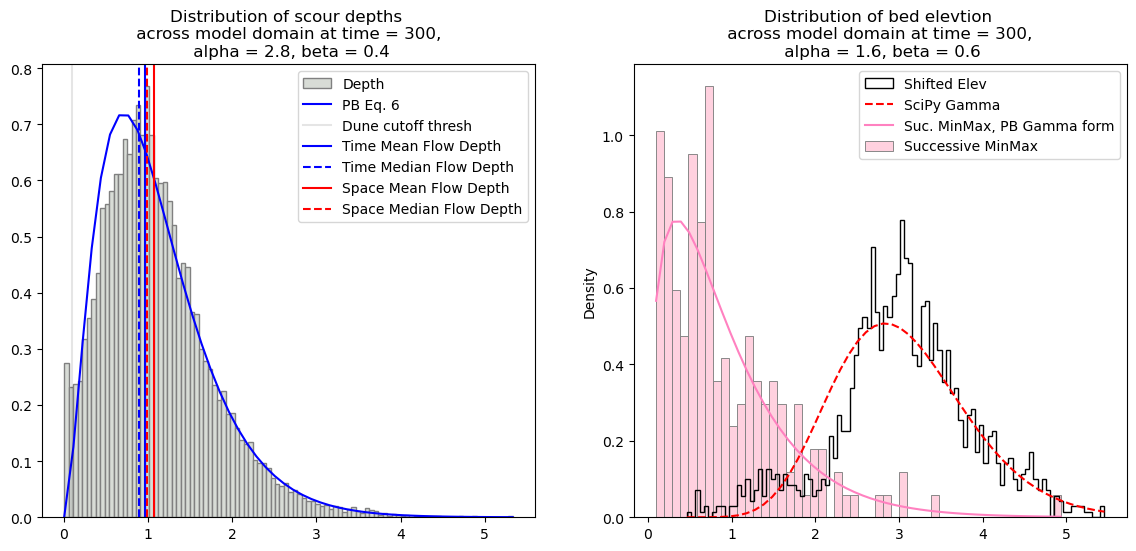

In [26]:
## MAKE PLOTS
fig, ax = plt.subplots(1, 2, figsize = (14, 6), dpi = 100)
ax[0].hist(datamaster[:, 4, t_topo][datamaster[:, 4, t_topo]>0.009], bins = 100, fc = 'xkcd:light grey', ec = 'grey', density = True, label = 'Depth');
# ax[1].hist(datamaster[:, 7, t_topo], bins = 100, fc = 'xkcd:light grey', ec = 'grey', density = True, label = 'True Elev');
sns.histplot(successive_heights_crop, bins = 50, fc = 'xkcd:light pink', ec = 'grey', stat = 'density', label = 'Successive MinMax', ax = ax[1]);
ax[1].hist(reset_elev, bins = 100, histtype = 'step', ec = 'k', density = True, label = 'Shifted Elev');

ax[0].plot(x_dep, pdf_dep_pb, 'b-', label = 'PB Eq. 6')
# ax[0].plot(x_dep, pdf_dep_sc, 'r--', label = 'SciPy Gamma')

# ax[1].plot(x_tpo, pdf_tpo_pb, 'b-', label = 'PB Eq. 6')
ax[1].plot(x_tpo, pdf_tpo_sc, 'r--', label = 'SciPy Gamma')
ax[1].plot(x_sucheights, pdf_sucheights, c = 'xkcd:pink', label = 'Suc. MinMax, PB Gamma form')


ax[0].axvline(0.1*np.nanmean(fullsection[:, :, 4]), c = 'k', alpha = 0.1, label = 'Dune cutoff thresh')
ax[0].axvline(np.nanmean(fullsection[:, :, 4]), c = 'b', ls = '-', label = 'Time Mean Flow Depth')
ax[0].axvline(np.nanmedian(fullsection[:, :, 4]), c = 'b', ls = '--', label = 'Time Median Flow Depth')

ax[0].axvline(np.nanmean(datamaster[:, 4, t_topo]), c = 'r', ls = '-', label = 'Space Mean Flow Depth')
ax[0].axvline(np.nanmedian(datamaster[:, 4, t_topo]), c = 'r', ls = '--', label = 'Space Median Flow Depth')

ax[0].set_title(f'Distribution of scour depths \n across model domain at time = {t_topo}, \n alpha = {np.round(a_dep, 1)}, beta = {np.round(b_dep, 1)}')
ax[1].set_title(f'Distribution of bed elevtion \n across model domain at time = {t_topo}, \n alpha = {np.round(a_sucheights, 1)}, beta = {np.round(b_sucheights, 1)}')

ax[0].legend()
ax[1].legend()

In [61]:
print(stats.variation(datamaster[:, 7, -1]), stats.variation(successive_heights_crop))

0.7345164584809231 0.7941141455674253


plt.figure(figsize = (30, 3), dpi = 1000, tight_layout = True)
plt.xlim(0, fullsection.shape[1])

for t in range(0, end_t):
    plt.plot(fullsection[t, :, 2], 'k', alpha = 0.1, lw = 0.1)
plt.plot(fullsection[t_end, :, 0], 'r--', lw = 0.1)
ax = plt.gca()
ax.set_aspect('10')
plt.savefig('fullsectionstrat.png')

Until I find a better way of doing this, I'm just measuring the vertical thickness between the unique elevations in every column of the stratigraphy (this will omit nans and omit repeatting surfaces that are there based on how I made the EH array)...Tbh this is probably the best way to do this.

In [27]:
set_heights_array = np.array([]) ## array of set_heights at 1m spacing along the full cross section
numsets = np.array([]) ## will tell us how many sets in eaach core
for col in range(0, fullsection.shape[1], 10):
    if len(np.unique(fullsection[:, col, 2][~np.isnan(fullsection[:, col, 2])])) > 1:
        unique_elevs = np.unique(fullsection[:, col, 2][~np.isnan(fullsection[:, col, 2])])
        diffs = unique_elevs[1:]-unique_elevs[:-1]
        numsets = np.concatenate((numsets, np.array([len(diffs)])), axis = 0)
        set_heights_array = np.concatenate((set_heights_array, diffs), axis = 0)

In the Ganti et al., 2020 paper they scale bedforms (ripples) as 0.1 bankfull height, so I'll use a cutoff of 0.1 * bankfull here, mean and median are roughly the same.  In Ganti 2013, they smoothed with a gaussian filter with a window = 0.25 mean bedform length

0.10771153387041839
% of data removed =  41.66418576957428


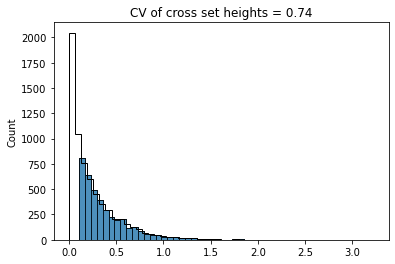

In [63]:
thresh = 0.1*np.nanmean(fullsection[:, :, 4]) ## 0.01
thresh = 0.1*np.nanmean(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.001]) ## height threshold to cut off bedforms
print(thresh)
xset_subset = set_heights_array[np.where(set_heights_array>thresh)]
meanxset = np.nanmean(xset_subset)

perc_cutoff = 1-(len(xset_subset)/len(set_heights_array))
plt.hist(set_heights_array, bins = 50, histtype = 'step', label = 'All set heights', ec = 'k')
plt.hist(xset_subset, bins = 50, label = 'set heights above thresh', fc = 'xkcd:light grey', ec = 'k')
print('% of data removed = ', perc_cutoff*100)
xset_cv = stats.variation(xset_subset)
# plt.hist(set_heights_list);
sns.histplot(xset_subset, bins = 50)
plt.title(f'CV of cross set heights = {np.round(xset_cv, 2)}');

Text(0.5, 0, 'Streamwise distance, m')

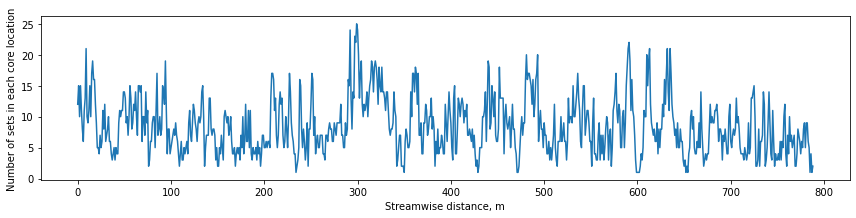

In [64]:
plt.figure(figsize = (12, 3), tight_layout = True)
# plt.xlim(0, fullsection.shape[1])

plt.plot(numsets)
plt.ylabel('Number of sets in each core location')
plt.xlabel('Streamwise distance, m')

Some summary statistics

## ???????

### Preservation Statistics from PB91

$$
\omega = \frac {\text{mean thicknessof preserved sets}}{\text{mean topographical height}}
$$

for topo folloing 2 paramma gamma:
$$ \omega = 0.8225/\alpha \text{   (bedforms)   and }\omega = 1.645/\alpha \text{   channels} $$

**New calculations using successive maxima and minima**

In [28]:
exp_SH = 1.645*b_sucheights ## expected set height from successive heights
exp_pres_SH_a = 1.645/a_sucheights#(stats.variation(successive_heights)**2) ##expected preservation from successive heights
exp_pres_SH_cv = 1.645*(stats.variation(successive_heights_crop)**2) ##using cv
exp_dep = 1.645*b_dep## expected set heights from depths
exp_pres_dep_a = 1.645/a_dep#(stats.variation(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.009])**2) ##expected preservation from depths
exp_pres_dep_cv = 1.645*(stats.variation(datamaster[:, 4, t_end][datamaster[:, 4, t_end]>0.009])**2) ## using cv

In [29]:
1.645*b_tpo ## expected set height, from topo reset

0.35381598816248194

In [30]:
1.645/a_tpo ##expected preserv

0.11592856561478217

In [33]:
mean_sucheight = np.mean(successive_heights_crop)
meanxset = 0.55
actual_pres_SH = meanxset/mean_sucheight
## if you use 1.645 you get entire preservation, if you use 0.8225 you get a value comparable to the actual preservation using the successive maxima and minima. 
## according to the paper if CV is high, preservaton should be hgh, but what is high??? our CV is 0.75 so im assuming that is high, but the preservation ratio is mid :((((
print(f'Mean Set Height: {np.round(meanxset, 5)}')
print(f'Mean Successive Height: {np.round(mean_sucheight, 5)}')
print(f'CV set height = {np.round(0.677, 5)}')
print(' ')
print(f'\u03C9_actual = {np.round(actual_pres_SH, 5)}')
print(f'\u03C9_est_from_SH_alpha = {np.round(exp_pres_SH_a, 5)}')
print(f'\u03C9_est_from_dep_alpha = {np.round(exp_pres_dep_a, 5)}')
print(f'\u03C9_est_from_SH_cv = {np.round(exp_pres_SH_cv, 5)}')
print(f'\u03C9_est_from_dep_cv = {np.round(exp_pres_dep_cv, 5)}')
print(' ')
print(f'expected set height from SH using maxima-minima = {np.round(exp_SH, 5)}')
print(f'expected set height from depths = {np.round(exp_dep, 5)}')

Mean Set Height: 0.55
Mean Successive Height: 0.92943
CV set height = 0.677
 
ω_actual = 0.59176
ω_est_from_SH_alpha = 1.03737
ω_est_from_dep_alpha = 0.58577
ω_est_from_SH_cv = 1.03737
ω_est_from_dep_cv = 0.59624
 
expected set height from SH using maxima-minima = 0.96416
expected set height from depths = 0.64782


Text(0.5, 0.98, 'Spatial Nyquist Frequency for Bars?')

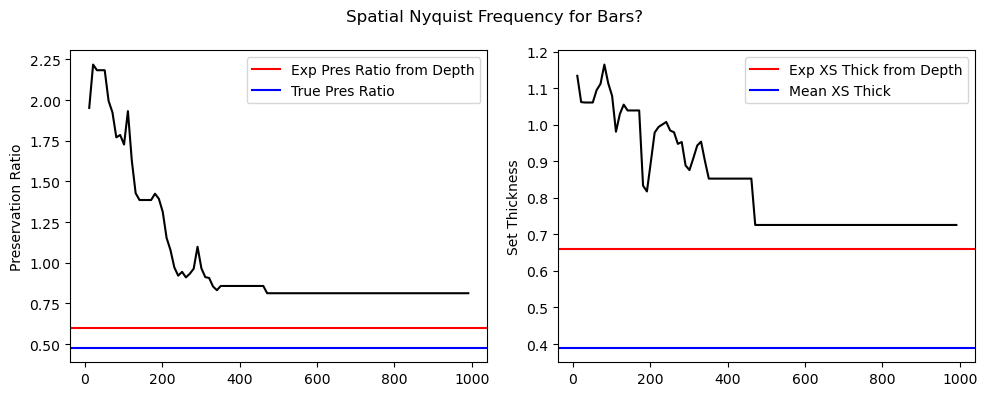

In [299]:
##create arrays to store results for each window
windowlength = np.arange(11, 1001, 10)
pbt_vals = np.empty([len(windowlength), 6])## store shape parameters, mean, and preservation and set thickness estimates at different windows

## array order: 0: window length, 1: alpha, 2: beta, 3: mean height, 4: exp pres, 5: exp set thick 
t_topo = 300
pol_ord = 2
pos_bars = xlocs_nonan[~np.isnan(fullnonans[:, :, 0][t_topo, :])]
for w, win in enumerate(windowlength):
    
    moving_topo = savgol_filter(fullnonans[:, :, 0][t_topo, :][~np.isnan(fullnonans[:, :, 0][t_topo, :])], win, pol_ord, mode = 'interp')
    topo_grad = (moving_topo[1:]-moving_topo[:-1])/(pos_bars[1:]-pos_bars[:-1])

    maxima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
    minima = moving_topo[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]
    # max_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]>0, topo_grad[1:]<0)]
    # min_xlocs = pos_bars[1:-1][np.logical_and(topo_grad[:-1]<0, topo_grad[1:]>0)]
    if len(maxima)>len(minima):
        sh = maxima[:len(minima)]-(minima)

    elif len(minima)>len(maxima):
        sh = maxima-minima[:len(maxima)]

    pbt_vals[w, 0] = win
    pbt_vals[w, 1] = alpha(sh)
    pbt_vals[w, 2] = beta(sh)
    pbt_vals[w, 3] = np.nanmean(sh)
    pbt_vals[w, 4] = 1.645/(pbt_vals[w, 2]**2/np.std(sh)**2)
    pbt_vals[w, 5] = 1.645*pbt_vals[w, 2]

fig, ax = plt.subplots(1, 2, figsize = (10, 4), dpi = 100, tight_layout = True, sharex = True)

##expected pres and actual pres
ax[0].plot(windowlength, pbt_vals[:, 4], 'k-')
ax[0].axhline(exp_pres_dep_a, c = 'r', label = 'Exp Pres Ratio from Depth')
ax[0].axhline(actual_pres_SH, c = 'b', label = 'True Pres Ratio')
ax[0].set_ylabel('Preservation Ratio')
ax[0].legend()
## expected mean set thick and actual mean
ax[1].plot(windowlength, pbt_vals[:, 5], 'k-')
ax[1].axhline(exp_dep, c = 'r', label = 'Exp XS Thick from Depth')
ax[1].axhline(meanxset, c = 'b', label = 'Mean XS Thick')
ax[1].legend()
ax[1].set_ylabel('Set Thickness')
fig.suptitle('Spatial Nyquist Frequency for Bars?')

### Trying again with main surfaces outlined

In [9]:
u_end = 1000
d_end = 9000
xlocs = np.linspace(u_end, d_end, fullsection.shape[1])

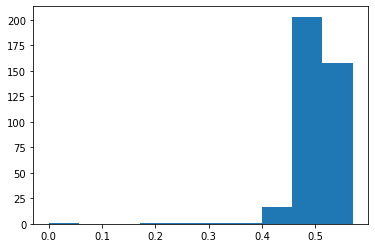

In [10]:
erocount = np.empty([end_t, 3]) #holding the count of non-nan elements to identiy major erosion/hiatal surfs
xloc_idx = np.arange(len(xlocs))
for row in range (0, end_t):
    length = int(xlocs.max()-xlocs.min()) #length of the section at time, t
    endpos = int(xloc_idx.max())
    startpos = int(xloc_idx.min())
    
    erocount[row, 0] = row #timestep value
    erocount[row, 1] = np.count_nonzero(~np.isnan(fullsection[:, :, 2][row, startpos:endpos])) #count number of EH surfs
    erocount[row, 2] = erocount[row, 1]/length #fraction of surf EH reworked

plt.hist(erocount[:, 2], bins = 10);
# plt.close()

In [11]:
threshperc = np.arange(50, 100) #range of percentiles to test the fir over
coverage = np.empty([1, len(xlocs)])

for i in threshperc:
    thresh_frac = np.percentile(erocount[:, 2], i) #fraction of surface we want reworked to call it a major surface
    big_times = erocount[np.where(erocount[:, 2] >= thresh_frac), 0]
    big_times = big_times.ravel()
    print(len(big_times))
    bounding_surfaces = np.empty([1, len(xlocs)+1]) #will store coordinates of main bounding surfaces plus the time of the surface
    bounding_surfaces[:] = np.nan


    for t in big_times:
        t = int(t)
    #ax[0].plot(xlocs, stratinterpcub[i, :], c='w', lw=1.5)#, color = cpick.to_rgba(i), lw = 1.5)
        #pull true topography
        boundscratch = np.append(t, fullsection[:, :, 1][t, :])
        bounding_surfaces = np.append(bounding_surfaces, np.reshape(boundscratch, [1, len(xlocs)+1]), axis=0)


    dummymatrix = np.empty_like(fullsection[:, :, 1])

    dummymatrix[:] = np.nan
    
# dont nee dummy matrix
    #count all non nan elements, subtract elements in the first column
    num_elements = np.count_nonzero(~np.isnan(bounding_surfaces))-len(bounding_surfaces)+1
    #num_elements = np.count_nonzero(~np.isnan(fullsection[:, :, 2]))
    #print(num_elements, len(bounding_surfaces))
    for column in range (1, len(xlocs)): #search corewise across the section
        uniquebounds = np.unique(bounding_surfaces[:, column][np.where(~np.isnan(bounding_surfaces[:, column]))]) #search bounding surfaces
        unique_eh_bounds = np.unique(fullsection[:, :, 2][:, column-1][np.where(~np.isnan(fullsection[:, :, 2][:, column-1]))]) #search erohiatal surfaces
        #uniquebounds = np.delete(uniquebounds, np.nan)
        #unique_eh_bounds = np.delete(unique_eh_bounds, np.nan)
        #print(uniquebounds, unique_eh_bounds)
        #print(np.intersect1d(uniquebounds, unique_eh_bounds))
        coverage[0, column] = len(np.intersect1d(uniquebounds, unique_eh_bounds))
    
    totalcoverage = np.sum(coverage) #total overlap of the two arrays
    total_coverage_frac = totalcoverage/num_elements

    
    if num_elements < np.count_nonzero(~np.isnan(fullsection[:, :, 2])):
        break
print('Best percentile = ', i, '. Coverage = ', total_coverage_frac)
bestperc = i

191
Best percentile =  50 . Coverage =  0.04110420242829882


(192, 8001) (8, 8001) (8, 8001)
number of surfaces deleted =  183


/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_24636/1545530695.py:23: RuntimeWarning: Mean of empty slice
  x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :]) #check to see hpw much sediment added at that time


(3000.0, 4000.0)

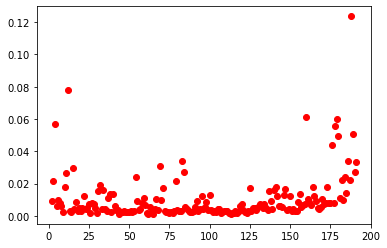

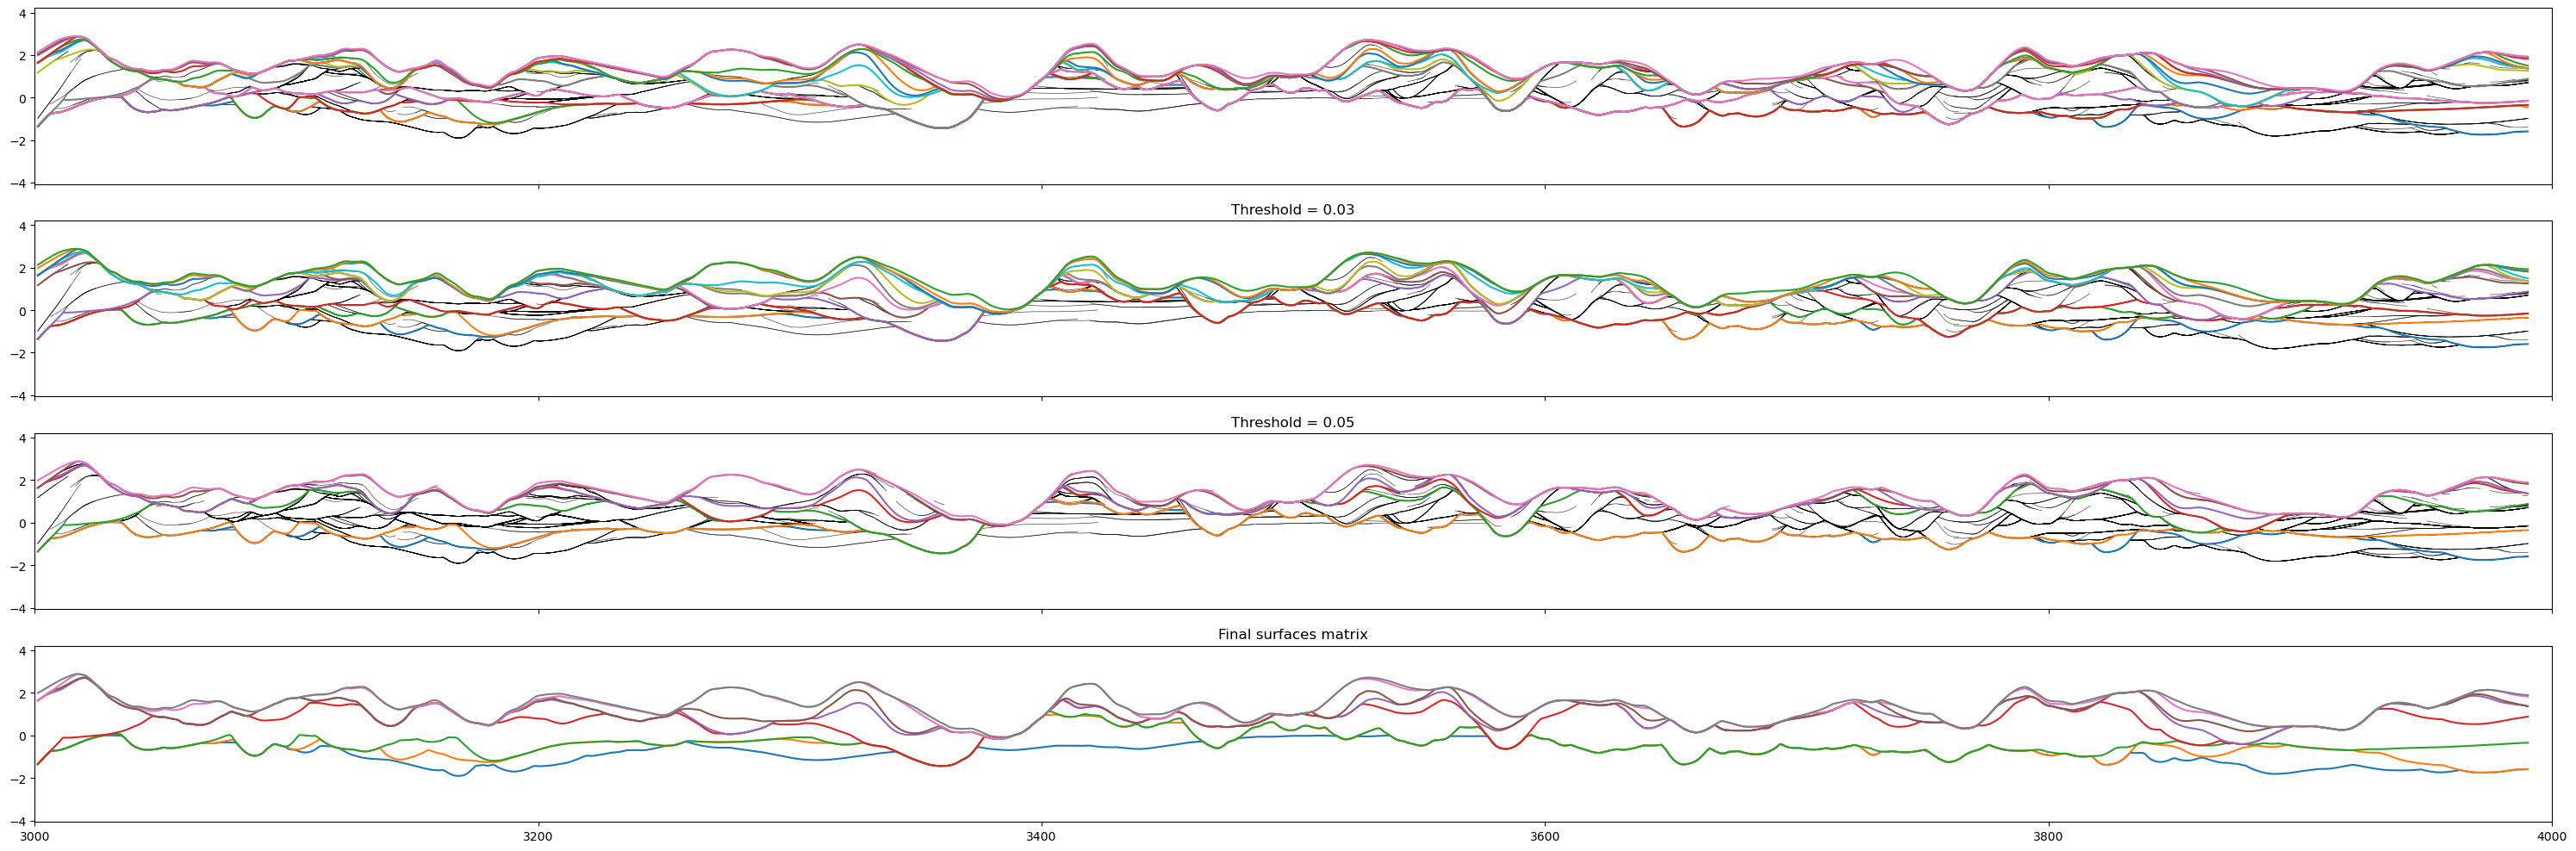

In [14]:
thickness = fullsection[1:, :, 0]-fullsection[:-1, :, 0]
##### look at what removing some different threshold thicknesses will do to the data

fig = plt.figure()

bd_surfs = np.zeros([1, len(xlocs)+1])
#print(fnl_surfs)

for i in range(2, bounding_surfaces.shape[0]):
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :])
    #print(x)
    
    plt.plot(i, x, 'ro')
plt.axhline(np.percentile(thickness, 70))    
fig, ax = plt.subplots(4, 1, figsize = (30,10), tight_layout = True, sharex = True, dpi = 100)
for i in range (0, 3):
    for j in range (0, end_t):
        ax[i].plot(xlocs, fullsection[:, :, 2][j, :], 'k',  lw = 0.5, alpha = 0.7)

mean_thickness_threshold = np.array([0.025, 0.030, 0.05])
#print(mean_thickness_threshold)
for i in range(1, bounding_surfaces.shape[0]): ##### bounding_surfaces row 0 is a row of nans, start from 2
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :]) #check to see hpw much sediment added at that time

    if x > mean_thickness_threshold[0]:
        ax[0].plot(xlocs, bounding_surfaces[i, 1:])
    
    if x > mean_thickness_threshold[1]:
        ax[1].plot(xlocs, bounding_surfaces[i, 1:])
        ax[1].set_title('Threshold = '+str(mean_thickness_threshold[1]))
    if x > mean_thickness_threshold.max():
        ax[2].plot(xlocs, bounding_surfaces[i, 1:])
        ax[2].set_title('Threshold = '+str(mean_thickness_threshold.max()))
        bd_surfs = np.append(bd_surfs, np.reshape(bounding_surfaces[i, :], [1, len(xlocs)+1]), axis = 0)
        
    #if x < 0.03:
        #print(i)
        

#print(fnl_surfs[0, :])
fnl_surfs = copy.deepcopy(bd_surfs)
fnl_surfs[0, 1:] = fullsection[:, :, 1][0, :]

#print(fnl_surfs[0, :])
print(bounding_surfaces.shape, bd_surfs.shape, fnl_surfs.shape)
print('number of surfaces deleted = ', (bounding_surfaces.shape[0]-1)-fnl_surfs.shape[0])

for i in range (0, len(fnl_surfs)):
    ax[3].plot(xlocs, fnl_surfs[i, 1:])
ax[3].set_title('Final surfaces matrix')
# ax[-1].set_xlim(xlocs.min(), xlocs.max())
ax[-1].set_xlim(3000, 4000)

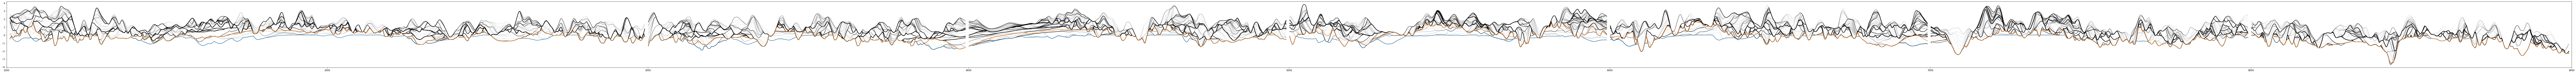

In [325]:
plt.figure(figsize=(200, 20))

for i in range (0, 381):
    plt.plot(xlocs, fullsection[i, :, 1], 'k', alpha = 0.1)
plt.plot(xlocs, fnl_surfs[0, 1:])
plt.plot(xlocs, fnl_surfs[1, 1:])
plt.xlim(1000, 9000)
ax = plt.gca()
ax.set_aspect(25)

### Preservation Statistics from Ganti et al., 2020

Text(0.5, 1.0, 'Originial Topographic Elevations & Preserved Elevations')

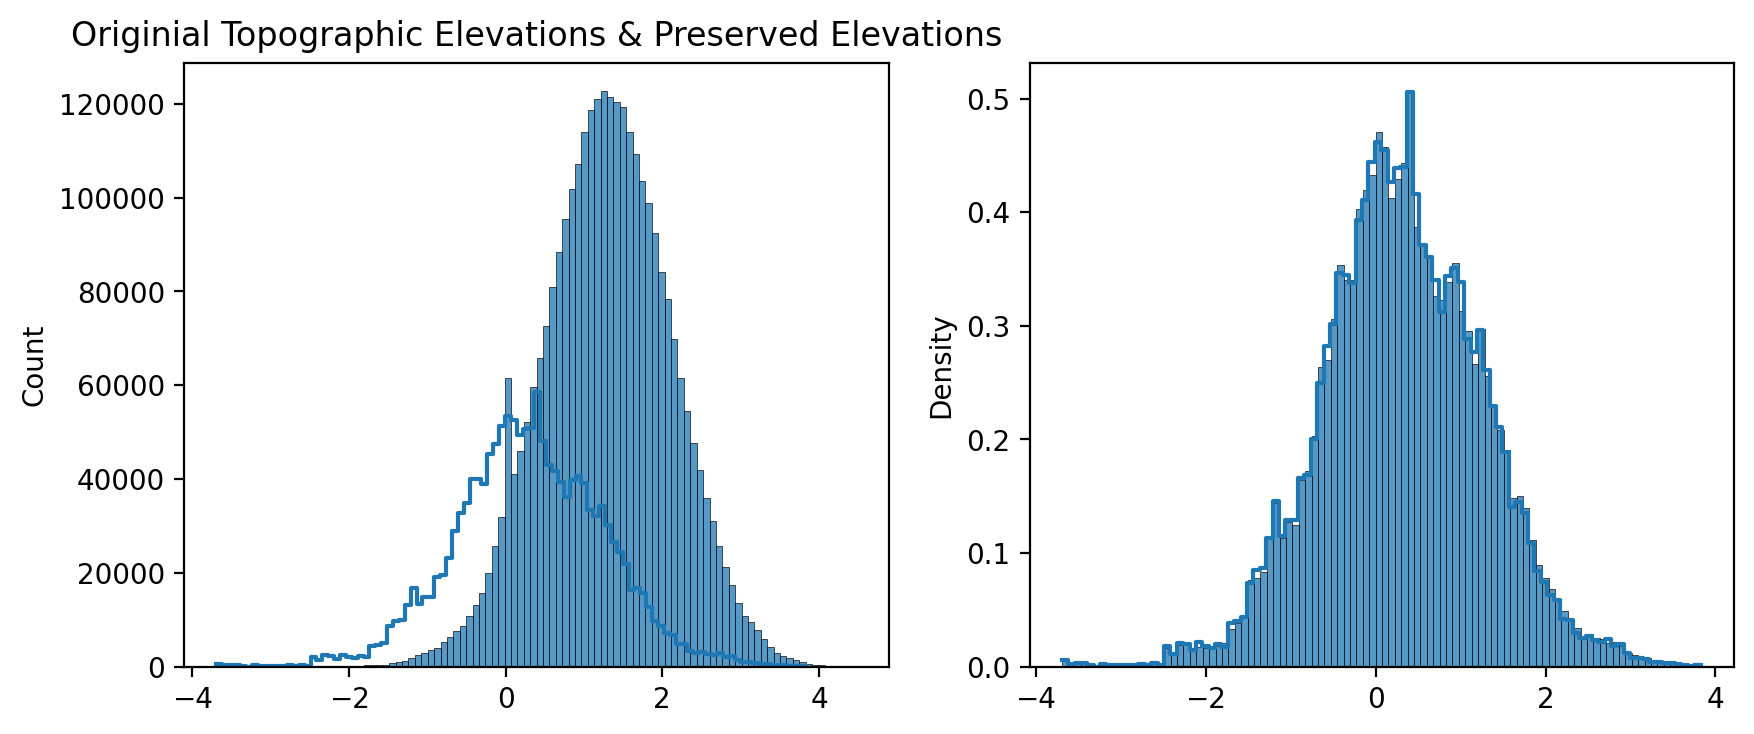

In [68]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), dpi = 200)
sns.histplot(fullsection[:, :, 0].ravel(), bins = 100, ax = ax[0]);
sns.histplot(fullsection[:, :, 1].ravel(), bins = 100, stat = 'density', ax = ax[1]);
sns.histplot(fullsection[:, :, 2].ravel(), bins = 100, element = 'step', ax = ax[0], fill=False);
sns.histplot(fullsection[:, :, 2].ravel(), bins = 100, element = 'step', stat = 'density', ax = ax[1], fill=False);
ax[0].set_title('Originial Topographic Elevations & Preserved Elevations')

Preserved elevations should be elevations not eroded or hiatused? Because those are the original elevations
Therefore, to do the original percentiles thing we should be considering strat that is not in the erohiatalsurf matrix <br>
$\Omega$ = $\frac{100-2(median ptile preserved)}{100}$ if $\Omega$ -> 1, all ordinary stuff preserved, if $\Omega$ -> 0, only extremes preserved

In [69]:
## Somehow each section got imported with 10m of nans so we have to remove that


In [70]:
percentiles = np.array([])

# for i in np.unique(np.round(fullnonans[1:, :, 0][np.isnan(fullnonans[1:, :, 2])], 2)): ##for original surfaces that have not been eroded
#     perc = np.array([stats.percentileofscore(fullnonans[:, :, 0].ravel(), i, kind = 'mean')])
#     percentiles = np.concatenate((percentiles, perc), axis = 0)
#     if len(percentiles)%10000 == 0:
#         print(len(percentiles))

# Using topographic heights?
for i in np.unique(np.round(fullnonans[1:, :, 0][np.isnan(fullnonans[1:, :, 2])], 2)): ##for original surfaces that have not been eroded
    perc = np.array([stats.percentileofscore(fullnonans[:, :, 0].ravel(), i, kind = 'mean')])
    percentiles = np.concatenate((percentiles, perc), axis = 0)
    if len(percentiles)%10000 == 0:
        print(len(percentiles))
# for t in range(0, percentiles.shape[0]):
    
#     for x in range (0, percentiles.if tshape[1]):
#         percentiles[t, x] = stats.percentileofscore(fullsection[:, :, 0], fullsection[t, x, 1], kind = 'rank')
        

In [134]:
np.save('/Users/safiya/Desktop/GantiPercentiles_Aug2022', percentiles)
# np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/streamwise-masters/fullsections/{dataloc}-centrefull', fullsection)

In [71]:
len(fullnonans[1:, :, 0][np.isnan(fullnonans[1:, :, 2])])

1479137

Median Ptile: 24.14999957036468
0.5170000085927063


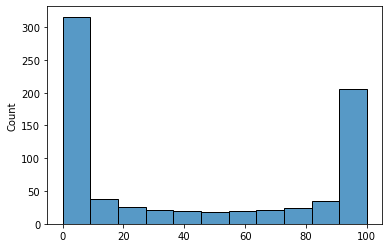

In [72]:
print(f'Median Ptile: {np.median(percentiles)}')
pei = (100-(2*np.median(percentiles)))/100 ## preservation extremality index
sns.histplot(percentiles)
print(pei)

In [ ]:
sns.histplot(fullnonans[:, :, 2].ravel());

(-0.5, 3.0)

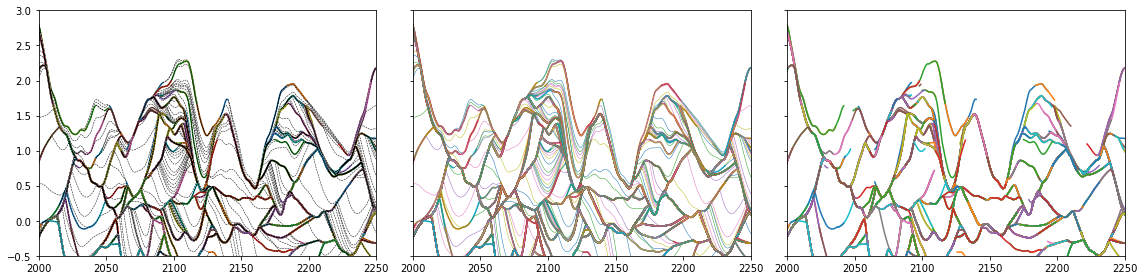

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (16, 4), tight_layout = True, sharex = True, sharey = True)
ehfill = copy.deepcopy(fullnonans[:, :, 2])
for t in range( -1, -end_t, -1):
    ehfill[t, :][np.isnan(ehfill[t, :])] = fullnonans[t, :, 1][np.isnan(ehfill[t, :])]
    ax[0].plot(ehfill[t, :], 'k--', lw = 0.5)
    ax[0].plot(fullnonans[t, :, 2], lw = 1.5)
    ax[1].plot(fullnonans[t, :, 1], lw = 0.5)
    ax[1].plot(fullnonans[t, :, 2], lw = 1.5)
    ax[2].plot(fullnonans[t, :, 2], lw = 1.5)

ax[0].set_xlim(2000, 2250)
ax[0].set_ylim(-0.5, 3)

In [57]:
ehsurfs = np.reshape(np.empty_like(fullnonans[1, :, 2]), [1, len(fullnonans[1, :, 2])]) 


for t in range (-1, -10, -1):
    # for xpos in range (0, fullnonans[:, :, 2].shape[1]):
        
    nanlocs = np.where(np.isnan(fullnonans[t, :, 2]))[0]
    for xpos in range(0, fullnonans[:, :, 2].shape[1]):
        xpospin = np.where(fullnonans[t, xpos, 2]==fullnonans[:, xpos, 2])[0]
        if xpospin != []:
            
            print(xpospin[0])
    print(len(nanlocs[0]))

(1, 7921)
379
375
375
375
375
372
372
361
361
361
361
361
361
361
361
361
375
375
377
374
374
373
373
373
373
373
373
373
374
375
375
375
375
375
375
374
374
374
374
380
379
379
379
379
372
366
366
366
366
366
366
366
366
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
380
380
380
380
380
380
380
380
380
380
380
380
356
293
318
318
318
330
330
330
336
336
336
336
336
351
351
351
351
343
343
343
343
343
373
373
373
373
373
373
373
373
373
373
373
372
372
358
352
378
378
352
353
353
353
353
353
353
353
353
351
342
323
323
323
323
323
322
322
321
319
378
378
379
379
379
379
379
379
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
379
357
358
358
358
358
358
380
380
380
380
380
379
379
379
379
379
379
379
379
349
349
336
334
160
160
160
160
160
160
160
160
160
181
176
176
328
328
331
331
331
331
331
331
331
331
331
331
356
356
356
356
356
356
356
356
356
356
380
380
380
380
380
380
274
274
274
278
288
288
288
288
296
296
296
300
300
300
30

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_24636/2382962583.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if xpospin != []:
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_24636/2382962583.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xpospin != []:


282
282
282
286
286
286
286
374
374
380
380
380
380
380
380
380
380
380
380
380
380
363
363
363
363
380
380
373
373
373
363
363
294
294
273
273
282
282
282
282
276
276
276
276
275
341
341
341
341
344
344
344
380
380
379
379
379
379
379
379
331
331
331
331
331
352
352
352
355
366
366
366
366
366
366
366
380
380
380
249
249
249
249
240
234
231
231
367
368
368
368
368
368
368
368
368
370
370
370
368
368
368
373
380
380
380
380
377
377
377
378
378
369
369
369
369
369
369
369
369
369
369
369
379
379
379
379
379
379
379
379
379
379
379
379
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
375
372
372
372
376
377
377
377
377
377
377
377
377
377
377
377
377
378
378
378
378
380
376
376
376
376
376
374
374
374
351
351
351
351
270
264
264
264
264
264
249
250
250
250
250
251
251
251
251
251
376
376
376
379
379
377
377
377
377
377
377
377
377
377
377
377
377
377
377
369
369
369
378
378
378
378
378
378
378
378
378
378
378
378
379
379
379
379
379


TypeError: object of type 'numpy.int64' has no len()

In [5]:
ehsurfs.shape


NameError: name 'ehsurfs' is not defined

In [13]:
for 

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-3.69363384, -3.6876592 , -3.65038051, ...,         nan,
                nan,         nan],
       [-3.69363384, -3.6876592 , -3.65038051, ...,         nan,
                nan,         nan],
       ...,
       [ 0.40434141,  0.5027317 ,  0.31861381, ...,  2.62422586,
         2.65655157,  0.47406093],
       [        nan,         nan,         nan, ...,  2.62422586,
         2.65655157,  0.47406093],
       [        nan,         nan,         nan, ...,  2.62422586,
         2.65655157,  0.47406093]])